## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs, target_len):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(target_len, activation = 'softmax')(x)
    model = keras.Model(inputs, outputs)
    return model


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()

import pandas as pd
import numpy as np

def normalize(x):
    return (x - x.min(0)) / x.ptp(0)

def gen_data(mean = 0, var = 1, SIZE = 20000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(25,5, SIZE)
    estrogen =  np.random.normal(bmi, 10) +  np.random.normal(mean,var, SIZE)
    
    age = np.random.normal(55,10, SIZE)
    genes = np.random.normal(age, 10,SIZE) +   np.random.normal(mean,var, SIZE)
    
    insomnia = np.random.normal(estrogen, 8,SIZE) +   np.random.normal(mean,var, SIZE)
    density = np.random.normal(estrogen, 4, SIZE) + np.random.normal(genes,12, SIZE) + np.random.normal(mean,var + 10, SIZE)

    cancer = np.zeros_like(density)
    m = np.mean(density)

    cancer[density > m] = np.random.binomial(n=1, p=0.08, size=len(density[density > m]))
    cancer[density <= m] = np.random.binomial(n=1, p=0.01, size=len(density[density <= m]))
    
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

def gen_data_perturbed(mean = 0, var = 1, SIZE = 20000):
    bmi = np.random.normal(30,3, SIZE)
    
    age = np.random.normal(60,14, SIZE) + np.random.normal(-bmi,var, SIZE) 
    income = np.random.normal(age, var,SIZE) + np.random.normal(10,12, SIZE)
    density = np.random.normal(-bmi,var, SIZE) + np.random.normal(-age,var, SIZE) + np.random.normal(mean,var, SIZE)
    cancer = np.zeros_like(density)
    m = np.mean(density)
    print(m)
    cancer[density > m] = np.random.binomial(n=1, p=0.08, size=len(density[density > m]))
    cancer[density <= m] = np.random.binomial(n=1, p=0.01, size=len(density[density <= m]))
    
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'income':income})
def gen_data_perturbed(mean = 2, var = 5, SIZE = 20000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(25,5, SIZE)
    estrogen =  np.random.normal(bmi, 10) +  np.random.normal(mean,var, SIZE)
    
    age = np.random.normal(55,10, SIZE)
    genes = np.random.normal(age, 10,SIZE) +   np.random.normal(mean,var, SIZE)
    
    insomnia = np.random.normal(estrogen, 8,SIZE) +   np.random.normal(mean,var, SIZE)
    density = np.random.normal(estrogen, 4, SIZE) + np.random.normal(genes,12, SIZE) + np.random.normal(mean,var + 10, SIZE)

    cancer = np.zeros_like(density)
    m = np.mean(density)

    cancer[density > m] = np.random.binomial(n=1, p=0.08, size=len(density[density > m]))
    cancer[density <= m] = np.random.binomial(n=1, p=0.01, size=len(density[density <= m]))
    
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()



from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =100
model_layers = [1024,512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/a' + str(i))

print(models, model_names)

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

inputs = ['bmi', 'density', 'age', 'genes', 'insomnia', 'estrogen']
target = ['cancer']
full_conx = get_pairs(inputs + target)
forced_conx = set({('age','genes'), ('bmi', 'estrogen'), ('estrogen', 'genes'),('estrogen', 'insomnia'), ('estrogen', 'density'), ('genes', 'density'), ('density', 'cancer')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )






df = gen_data(SIZE = 200000)
cancer_df = df[df['cancer'] == 1]

ben_df = df[df['cancer'] == 0][:len(cancer_df)]

df = cancer_df.append(ben_df, ignore_index=True)
print(len(cancer_df), len(ben_df), len(df))


X = df[inputs].values
X = normalize(X)
y = df[target].values
y = to_categorical(y)

val_df = gen_data(SIZE = 2000)

x_val = df[inputs].values
x_val = normalize(x_val)
y_val = df[target].values
y_val = to_categorical(y_val)

get_bic(df,prior)

/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512]

-498436.0349539574

In [2]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs), 2)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.01, momentum = 0.9, ), loss='categorical_crossentropy', metrics = ['accuracy'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/a0
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 188us/step - loss: 0.6619 - acc: 0.6131 - val_loss: 0.6383 - val_acc: 0.6263

Epoch 00001: val_loss improved from inf to 0.63830, saving model to temp/a0
Epoch 2/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6369 - acc: 0.6507 - val_loss: 0.6278 - val_acc: 0.6722

Epoch 00002: val_loss improved from 0.63830 to 0.62780, saving model to temp/a0
Epoch 3/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6313 - acc: 0.6573 - val_loss: 0.6234 - val_acc: 0.6825

Epoch 00003: val_loss improved from 0.62780 to 0.62340, saving model to temp/a0
Epoch 4/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6251 - acc: 0.6673 - val_loss: 0.6203 - val_acc: 0.6778

Epoch 00004: val_loss improved from 0.62340 to 0.62028, saving model to temp/a0
Epoch 5/20
17748/17748 [==============================] - 3s 148us/ste

17748/17748 [==============================] - 3s 157us/step - loss: 0.6618 - acc: 0.6121 - val_loss: 0.6520 - val_acc: 0.5796

Epoch 00001: val_loss improved from inf to 0.65196, saving model to temp/a3
Epoch 2/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6348 - acc: 0.6489 - val_loss: 0.6284 - val_acc: 0.6755

Epoch 00002: val_loss improved from 0.65196 to 0.62837, saving model to temp/a3
Epoch 3/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6295 - acc: 0.6576 - val_loss: 0.6273 - val_acc: 0.6868

Epoch 00003: val_loss improved from 0.62837 to 0.62732, saving model to temp/a3
Epoch 4/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6254 - acc: 0.6670 - val_loss: 0.6205 - val_acc: 0.6601

Epoch 00004: val_loss improved from 0.62732 to 0.62049, saving model to temp/a3
Epoch 5/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6227 - acc: 0.6662 - val_loss: 0.6170 - val_acc: 0.6893



17748/17748 [==============================] - 3s 148us/step - loss: 0.6221 - acc: 0.6724 - val_loss: 0.6219 - val_acc: 0.6525

Epoch 00005: val_loss did not improve from 0.62049
Epoch 6/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6215 - acc: 0.6749 - val_loss: 0.6224 - val_acc: 0.6795

Epoch 00006: val_loss did not improve from 0.62049
Epoch 00006: early stopping
temp/a7
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 158us/step - loss: 0.6615 - acc: 0.6102 - val_loss: 0.6367 - val_acc: 0.6703

Epoch 00001: val_loss improved from inf to 0.63669, saving model to temp/a7
Epoch 2/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6382 - acc: 0.6462 - val_loss: 0.6401 - val_acc: 0.6053

Epoch 00002: val_loss did not improve from 0.63669
Epoch 3/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6314 - acc: 0.6547 - val_loss: 0.6245 - val_acc: 0.6594

E


Epoch 00004: val_loss improved from 0.62729 to 0.62255, saving model to temp/a10
Epoch 5/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6226 - acc: 0.6707 - val_loss: 0.6267 - val_acc: 0.6412

Epoch 00005: val_loss did not improve from 0.62255
Epoch 6/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6208 - acc: 0.6731 - val_loss: 0.6148 - val_acc: 0.6845

Epoch 00006: val_loss improved from 0.62255 to 0.61483, saving model to temp/a10
Epoch 7/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6170 - acc: 0.6771 - val_loss: 0.6279 - val_acc: 0.6644

Epoch 00007: val_loss did not improve from 0.61483
Epoch 8/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6162 - acc: 0.6790 - val_loss: 0.6198 - val_acc: 0.6771

Epoch 00008: val_loss did not improve from 0.61483
Epoch 00008: early stopping
temp/a11
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [=================


Epoch 00011: val_loss improved from 0.61083 to 0.60919, saving model to temp/a13
Epoch 12/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6122 - acc: 0.6818 - val_loss: 0.6086 - val_acc: 0.6853

Epoch 00012: val_loss improved from 0.60919 to 0.60859, saving model to temp/a13
Epoch 13/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6125 - acc: 0.6800 - val_loss: 0.6070 - val_acc: 0.6882

Epoch 00013: val_loss improved from 0.60859 to 0.60698, saving model to temp/a13
Epoch 14/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6121 - acc: 0.6820 - val_loss: 0.6088 - val_acc: 0.6943

Epoch 00014: val_loss did not improve from 0.60698
Epoch 15/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6121 - acc: 0.6818 - val_loss: 0.6115 - val_acc: 0.6734

Epoch 00015: val_loss did not improve from 0.60698
Epoch 00015: early stopping
temp/a14
Train on 17748 samples, validate on 17748 samples
Epoch 1

17748/17748 [==============================] - 3s 146us/step - loss: 0.6210 - acc: 0.6746 - val_loss: 0.6191 - val_acc: 0.6574

Epoch 00006: val_loss improved from 0.62467 to 0.61907, saving model to temp/a16
Epoch 7/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6208 - acc: 0.6747 - val_loss: 0.6135 - val_acc: 0.6886

Epoch 00007: val_loss improved from 0.61907 to 0.61352, saving model to temp/a16
Epoch 8/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6166 - acc: 0.6793 - val_loss: 0.6227 - val_acc: 0.6729

Epoch 00008: val_loss did not improve from 0.61352
Epoch 9/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6164 - acc: 0.6775 - val_loss: 0.6144 - val_acc: 0.6903

Epoch 00009: val_loss did not improve from 0.61352
Epoch 00009: early stopping
temp/a17
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6629 - acc: 0.6078 - v

17748/17748 [==============================] - 3s 145us/step - loss: 0.6170 - acc: 0.6769 - val_loss: 0.6107 - val_acc: 0.6941

Epoch 00009: val_loss improved from 0.61214 to 0.61065, saving model to temp/a19
Epoch 10/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6150 - acc: 0.6799 - val_loss: 0.6188 - val_acc: 0.6533

Epoch 00010: val_loss did not improve from 0.61065
Epoch 11/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6141 - acc: 0.6800 - val_loss: 0.6161 - val_acc: 0.6628

Epoch 00011: val_loss did not improve from 0.61065
Epoch 00011: early stopping
temp/a20
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 157us/step - loss: 0.6620 - acc: 0.6092 - val_loss: 0.6405 - val_acc: 0.6160

Epoch 00001: val_loss improved from inf to 0.64052, saving model to temp/a20
Epoch 2/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6372 - acc: 0.6511 - val

17748/17748 [==============================] - 3s 147us/step - loss: 0.6194 - acc: 0.6747 - val_loss: 0.6296 - val_acc: 0.6676

Epoch 00006: val_loss did not improve from 0.61763
Epoch 7/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6172 - acc: 0.6769 - val_loss: 0.6285 - val_acc: 0.6607

Epoch 00007: val_loss did not improve from 0.61763
Epoch 00007: early stopping
temp/a24
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 158us/step - loss: 0.6599 - acc: 0.6106 - val_loss: 0.6414 - val_acc: 0.6688

Epoch 00001: val_loss improved from inf to 0.64136, saving model to temp/a24
Epoch 2/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6352 - acc: 0.6502 - val_loss: 0.6354 - val_acc: 0.6167

Epoch 00002: val_loss improved from 0.64136 to 0.63538, saving model to temp/a24
Epoch 3/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6301 - acc: 0.6604 - val_l

17748/17748 [==============================] - 3s 146us/step - loss: 0.6258 - acc: 0.6662 - val_loss: 0.6279 - val_acc: 0.6810

Epoch 00004: val_loss did not improve from 0.62386
Epoch 5/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6234 - acc: 0.6666 - val_loss: 0.6177 - val_acc: 0.6725

Epoch 00005: val_loss improved from 0.62386 to 0.61769, saving model to temp/a27
Epoch 6/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6200 - acc: 0.6756 - val_loss: 0.6213 - val_acc: 0.6826

Epoch 00006: val_loss did not improve from 0.61769
Epoch 7/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6184 - acc: 0.6735 - val_loss: 0.6176 - val_acc: 0.6909

Epoch 00007: val_loss improved from 0.61769 to 0.61762, saving model to temp/a27
Epoch 00007: early stopping
temp/a28
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6634 - acc: 0.6056 - v

17748/17748 [==============================] - 3s 146us/step - loss: 0.6318 - acc: 0.6571 - val_loss: 0.6234 - val_acc: 0.6540

Epoch 00003: val_loss improved from 0.63114 to 0.62340, saving model to temp/a31
Epoch 4/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6264 - acc: 0.6654 - val_loss: 0.6251 - val_acc: 0.6849

Epoch 00004: val_loss did not improve from 0.62340
Epoch 5/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6221 - acc: 0.6698 - val_loss: 0.6154 - val_acc: 0.6826

Epoch 00005: val_loss improved from 0.62340 to 0.61543, saving model to temp/a31
Epoch 6/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6192 - acc: 0.6762 - val_loss: 0.6176 - val_acc: 0.6917

Epoch 00006: val_loss did not improve from 0.61543
Epoch 7/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6182 - acc: 0.6763 - val_loss: 0.6191 - val_acc: 0.6537

Epoch 00007: val_loss did not improve from 0.61543
E

Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 158us/step - loss: 0.6646 - acc: 0.5991 - val_loss: 0.6423 - val_acc: 0.6108

Epoch 00001: val_loss improved from inf to 0.64228, saving model to temp/a35
Epoch 2/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6383 - acc: 0.6443 - val_loss: 0.6459 - val_acc: 0.5944

Epoch 00002: val_loss did not improve from 0.64228
Epoch 3/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6292 - acc: 0.6579 - val_loss: 0.6226 - val_acc: 0.6632

Epoch 00003: val_loss improved from 0.64228 to 0.62264, saving model to temp/a35
Epoch 4/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6238 - acc: 0.6689 - val_loss: 0.6197 - val_acc: 0.6624

Epoch 00004: val_loss improved from 0.62264 to 0.61966, saving model to temp/a35
Epoch 5/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6218 - acc: 0.6726 - v


Epoch 00010: val_loss did not improve from 0.61143
Epoch 00010: early stopping
temp/a39
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6637 - acc: 0.6047 - val_loss: 0.6383 - val_acc: 0.6582

Epoch 00001: val_loss improved from inf to 0.63828, saving model to temp/a39
Epoch 2/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6381 - acc: 0.6484 - val_loss: 0.6279 - val_acc: 0.6769

Epoch 00002: val_loss improved from 0.63828 to 0.62790, saving model to temp/a39
Epoch 3/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6292 - acc: 0.6629 - val_loss: 0.6223 - val_acc: 0.6733

Epoch 00003: val_loss improved from 0.62790 to 0.62225, saving model to temp/a39
Epoch 4/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6251 - acc: 0.6681 - val_loss: 0.6395 - val_acc: 0.6555

Epoch 00004: val_loss did not improve from 0.62225
Epoch 5/20
1774


Epoch 00006: val_loss improved from 0.61856 to 0.61352, saving model to temp/a43
Epoch 7/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6181 - acc: 0.6764 - val_loss: 0.6164 - val_acc: 0.6626

Epoch 00007: val_loss did not improve from 0.61352
Epoch 8/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6168 - acc: 0.6786 - val_loss: 0.6121 - val_acc: 0.6922

Epoch 00008: val_loss improved from 0.61352 to 0.61213, saving model to temp/a43
Epoch 9/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6149 - acc: 0.6789 - val_loss: 0.6122 - val_acc: 0.6803

Epoch 00009: val_loss did not improve from 0.61213
Epoch 10/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6146 - acc: 0.6778 - val_loss: 0.6096 - val_acc: 0.6925

Epoch 00010: val_loss improved from 0.61213 to 0.60965, saving model to temp/a43
Epoch 11/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6126 - acc: 0.

17748/17748 [==============================] - 3s 147us/step - loss: 0.6176 - acc: 0.6791 - val_loss: 0.6152 - val_acc: 0.6709

Epoch 00007: val_loss improved from 0.61653 to 0.61515, saving model to temp/a46
Epoch 8/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6157 - acc: 0.6827 - val_loss: 0.6113 - val_acc: 0.6784

Epoch 00008: val_loss improved from 0.61515 to 0.61129, saving model to temp/a46
Epoch 9/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6151 - acc: 0.6773 - val_loss: 0.6101 - val_acc: 0.6840

Epoch 00009: val_loss improved from 0.61129 to 0.61015, saving model to temp/a46
Epoch 10/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6133 - acc: 0.6792 - val_loss: 0.6096 - val_acc: 0.6909

Epoch 00010: val_loss improved from 0.61015 to 0.60962, saving model to temp/a46
Epoch 11/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6135 - acc: 0.6802 - val_loss: 0.6084 - val_acc

17748/17748 [==============================] - 3s 148us/step - loss: 0.6117 - acc: 0.6841 - val_loss: 0.6071 - val_acc: 0.6940

Epoch 00011: val_loss improved from 0.60947 to 0.60707, saving model to temp/a49
Epoch 12/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6125 - acc: 0.6828 - val_loss: 0.6083 - val_acc: 0.6867

Epoch 00012: val_loss did not improve from 0.60707
Epoch 13/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6113 - acc: 0.6817 - val_loss: 0.6164 - val_acc: 0.6841

Epoch 00013: val_loss did not improve from 0.60707
Epoch 00013: early stopping
temp/a50
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6638 - acc: 0.6013 - val_loss: 0.6383 - val_acc: 0.6566

Epoch 00001: val_loss improved from inf to 0.63828, saving model to temp/a50
Epoch 2/20
17748/17748 [==============================] - 3s 142us/step - loss: 0.6384 - acc: 0.6426 - val

Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 157us/step - loss: 0.6629 - acc: 0.6066 - val_loss: 0.6365 - val_acc: 0.6551

Epoch 00001: val_loss improved from inf to 0.63653, saving model to temp/a53
Epoch 2/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6360 - acc: 0.6488 - val_loss: 0.6282 - val_acc: 0.6813

Epoch 00002: val_loss improved from 0.63653 to 0.62818, saving model to temp/a53
Epoch 3/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6305 - acc: 0.6560 - val_loss: 0.6336 - val_acc: 0.6248

Epoch 00003: val_loss did not improve from 0.62818
Epoch 4/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6263 - acc: 0.6644 - val_loss: 0.6186 - val_acc: 0.6785

Epoch 00004: val_loss improved from 0.62818 to 0.61855, saving model to temp/a53
Epoch 5/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6232 - acc: 0.6687 - v

17748/17748 [==============================] - 3s 146us/step - loss: 0.6268 - acc: 0.6660 - val_loss: 0.6184 - val_acc: 0.6848

Epoch 00004: val_loss improved from 0.63208 to 0.61841, saving model to temp/a57
Epoch 5/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6231 - acc: 0.6680 - val_loss: 0.6160 - val_acc: 0.6774

Epoch 00005: val_loss improved from 0.61841 to 0.61602, saving model to temp/a57
Epoch 6/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6191 - acc: 0.6744 - val_loss: 0.6179 - val_acc: 0.6659

Epoch 00006: val_loss did not improve from 0.61602
Epoch 7/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6182 - acc: 0.6769 - val_loss: 0.6242 - val_acc: 0.6429

Epoch 00007: val_loss did not improve from 0.61602
Epoch 00007: early stopping
temp/a58
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 157us/step - loss: 0.6611 - acc: 0.6102 - v


Epoch 00009: val_loss did not improve from 0.61083
Epoch 10/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6146 - acc: 0.6787 - val_loss: 0.6123 - val_acc: 0.6771

Epoch 00010: val_loss did not improve from 0.61083
Epoch 00010: early stopping
temp/a61
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 163us/step - loss: 0.6655 - acc: 0.6005 - val_loss: 0.6397 - val_acc: 0.6390

Epoch 00001: val_loss improved from inf to 0.63966, saving model to temp/a61
Epoch 2/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6380 - acc: 0.6482 - val_loss: 0.6330 - val_acc: 0.6283

Epoch 00002: val_loss improved from 0.63966 to 0.63296, saving model to temp/a61
Epoch 3/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6307 - acc: 0.6597 - val_loss: 0.6251 - val_acc: 0.6877

Epoch 00003: val_loss improved from 0.63296 to 0.62512, saving model to temp/a61
Epoch 4/20
177

17748/17748 [==============================] - 3s 148us/step - loss: 0.6152 - acc: 0.6772 - val_loss: 0.6116 - val_acc: 0.6876

Epoch 00010: val_loss did not improve from 0.61020
Epoch 11/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6130 - acc: 0.6818 - val_loss: 0.6138 - val_acc: 0.6673

Epoch 00011: val_loss did not improve from 0.61020
Epoch 00011: early stopping
temp/a65
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 158us/step - loss: 0.6632 - acc: 0.6058 - val_loss: 0.6392 - val_acc: 0.6682

Epoch 00001: val_loss improved from inf to 0.63915, saving model to temp/a65
Epoch 2/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6364 - acc: 0.6468 - val_loss: 0.6341 - val_acc: 0.6349

Epoch 00002: val_loss improved from 0.63915 to 0.63411, saving model to temp/a65
Epoch 3/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6293 - acc: 0.6628 - val_

17748/17748 [==============================] - 3s 157us/step - loss: 0.6619 - acc: 0.6082 - val_loss: 0.6353 - val_acc: 0.6636

Epoch 00001: val_loss improved from inf to 0.63535, saving model to temp/a68
Epoch 2/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6382 - acc: 0.6459 - val_loss: 0.6302 - val_acc: 0.6442

Epoch 00002: val_loss improved from 0.63535 to 0.63024, saving model to temp/a68
Epoch 3/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6311 - acc: 0.6548 - val_loss: 0.6225 - val_acc: 0.6786

Epoch 00003: val_loss improved from 0.63024 to 0.62254, saving model to temp/a68
Epoch 4/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6254 - acc: 0.6689 - val_loss: 0.6199 - val_acc: 0.6678

Epoch 00004: val_loss improved from 0.62254 to 0.61991, saving model to temp/a68
Epoch 5/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6221 - acc: 0.6741 - val_loss: 0.6162 - val_acc: 0.69


Epoch 00006: val_loss did not improve from 0.61746
Epoch 00006: early stopping
temp/a72
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6625 - acc: 0.6087 - val_loss: 0.6372 - val_acc: 0.6388

Epoch 00001: val_loss improved from inf to 0.63724, saving model to temp/a72
Epoch 2/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6375 - acc: 0.6464 - val_loss: 0.6296 - val_acc: 0.6396

Epoch 00002: val_loss improved from 0.63724 to 0.62959, saving model to temp/a72
Epoch 3/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6300 - acc: 0.6592 - val_loss: 0.6229 - val_acc: 0.6638

Epoch 00003: val_loss improved from 0.62959 to 0.62291, saving model to temp/a72
Epoch 4/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6251 - acc: 0.6686 - val_loss: 0.6198 - val_acc: 0.6698

Epoch 00004: val_loss improved from 0.62291 to 0.61981, saving mod


Epoch 00008: val_loss improved from 0.61239 to 0.61222, saving model to temp/a74
Epoch 9/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6172 - acc: 0.6768 - val_loss: 0.6118 - val_acc: 0.6729

Epoch 00009: val_loss improved from 0.61222 to 0.61184, saving model to temp/a74
Epoch 10/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6133 - acc: 0.6811 - val_loss: 0.6299 - val_acc: 0.6555

Epoch 00010: val_loss did not improve from 0.61184
Epoch 11/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6143 - acc: 0.6788 - val_loss: 0.6086 - val_acc: 0.6855

Epoch 00011: val_loss improved from 0.61184 to 0.60862, saving model to temp/a74
Epoch 12/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6131 - acc: 0.6802 - val_loss: 0.6124 - val_acc: 0.6692

Epoch 00012: val_loss did not improve from 0.60862
Epoch 13/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6121 - acc: 


Epoch 00010: val_loss did not improve from 0.61005
Epoch 00010: early stopping
temp/a78
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 154us/step - loss: 0.6632 - acc: 0.6081 - val_loss: 0.6545 - val_acc: 0.6457

Epoch 00001: val_loss improved from inf to 0.65448, saving model to temp/a78
Epoch 2/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6368 - acc: 0.6508 - val_loss: 0.6354 - val_acc: 0.6769

Epoch 00002: val_loss improved from 0.65448 to 0.63541, saving model to temp/a78
Epoch 3/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6314 - acc: 0.6590 - val_loss: 0.6298 - val_acc: 0.6296

Epoch 00003: val_loss improved from 0.63541 to 0.62978, saving model to temp/a78
Epoch 4/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6270 - acc: 0.6621 - val_loss: 0.6195 - val_acc: 0.6773

Epoch 00004: val_loss improved from 0.62978 to 0.61954, saving mod

17748/17748 [==============================] - 3s 148us/step - loss: 0.6270 - acc: 0.6656 - val_loss: 0.6209 - val_acc: 0.6655

Epoch 00004: val_loss improved from 0.62482 to 0.62091, saving model to temp/a81
Epoch 5/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6237 - acc: 0.6670 - val_loss: 0.6237 - val_acc: 0.6451

Epoch 00005: val_loss did not improve from 0.62091
Epoch 6/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6206 - acc: 0.6739 - val_loss: 0.6182 - val_acc: 0.6608

Epoch 00006: val_loss improved from 0.62091 to 0.61815, saving model to temp/a81
Epoch 7/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6190 - acc: 0.6769 - val_loss: 0.6199 - val_acc: 0.6811

Epoch 00007: val_loss did not improve from 0.61815
Epoch 8/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6157 - acc: 0.6794 - val_loss: 0.6235 - val_acc: 0.6476

Epoch 00008: val_loss did not improve from 0.61815
E

17748/17748 [==============================] - 3s 147us/step - loss: 0.6182 - acc: 0.6731 - val_loss: 0.6231 - val_acc: 0.6761

Epoch 00007: val_loss did not improve from 0.61457
Epoch 8/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6149 - acc: 0.6830 - val_loss: 0.6126 - val_acc: 0.6909

Epoch 00008: val_loss improved from 0.61457 to 0.61256, saving model to temp/a85
Epoch 9/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6142 - acc: 0.6826 - val_loss: 0.6137 - val_acc: 0.6900

Epoch 00009: val_loss did not improve from 0.61256
Epoch 10/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6150 - acc: 0.6791 - val_loss: 0.6104 - val_acc: 0.6899

Epoch 00010: val_loss improved from 0.61256 to 0.61041, saving model to temp/a85
Epoch 11/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6154 - acc: 0.6780 - val_loss: 0.6155 - val_acc: 0.6846

Epoch 00011: val_loss did not improve from 0.61041

17748/17748 [==============================] - 3s 146us/step - loss: 0.6171 - acc: 0.6774 - val_loss: 0.6188 - val_acc: 0.6833

Epoch 00007: val_loss did not improve from 0.61615
Epoch 00007: early stopping
temp/a89
Train on 17748 samples, validate on 17748 samples
Epoch 1/20
17748/17748 [==============================] - 3s 156us/step - loss: 0.6625 - acc: 0.6092 - val_loss: 0.6454 - val_acc: 0.6627

Epoch 00001: val_loss improved from inf to 0.64541, saving model to temp/a89
Epoch 2/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6386 - acc: 0.6479 - val_loss: 0.6286 - val_acc: 0.6570

Epoch 00002: val_loss improved from 0.64541 to 0.62861, saving model to temp/a89
Epoch 3/20
17748/17748 [==============================] - 3s 148us/step - loss: 0.6317 - acc: 0.6562 - val_loss: 0.6234 - val_acc: 0.6632

Epoch 00003: val_loss improved from 0.62861 to 0.62344, saving model to temp/a89
Epoch 4/20
17748/17748 [==============================] - 3s 147us/step - loss

17748/17748 [==============================] - 3s 158us/step - loss: 0.6650 - acc: 0.6027 - val_loss: 0.6394 - val_acc: 0.6687

Epoch 00001: val_loss improved from inf to 0.63942, saving model to temp/a93
Epoch 2/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6368 - acc: 0.6460 - val_loss: 0.6266 - val_acc: 0.6485

Epoch 00002: val_loss improved from 0.63942 to 0.62657, saving model to temp/a93
Epoch 3/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6292 - acc: 0.6611 - val_loss: 0.6358 - val_acc: 0.6197

Epoch 00003: val_loss did not improve from 0.62657
Epoch 4/20
17748/17748 [==============================] - 3s 144us/step - loss: 0.6256 - acc: 0.6660 - val_loss: 0.6195 - val_acc: 0.6664

Epoch 00004: val_loss improved from 0.62657 to 0.61950, saving model to temp/a93
Epoch 5/20
17748/17748 [==============================] - 3s 145us/step - loss: 0.6224 - acc: 0.6700 - val_loss: 0.6165 - val_acc: 0.6917

Epoch 00005: val_loss impr

17748/17748 [==============================] - 3s 145us/step - loss: 0.6237 - acc: 0.6698 - val_loss: 0.6215 - val_acc: 0.6515

Epoch 00005: val_loss improved from 0.62668 to 0.62149, saving model to temp/a96
Epoch 6/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6200 - acc: 0.6706 - val_loss: 0.6245 - val_acc: 0.6457

Epoch 00006: val_loss did not improve from 0.62149
Epoch 7/20
17748/17748 [==============================] - 3s 146us/step - loss: 0.6185 - acc: 0.6725 - val_loss: 0.6127 - val_acc: 0.6857

Epoch 00007: val_loss improved from 0.62149 to 0.61272, saving model to temp/a96
Epoch 8/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6164 - acc: 0.6786 - val_loss: 0.6140 - val_acc: 0.6918

Epoch 00008: val_loss did not improve from 0.61272
Epoch 9/20
17748/17748 [==============================] - 3s 149us/step - loss: 0.6153 - acc: 0.6772 - val_loss: 0.6117 - val_acc: 0.6927

Epoch 00009: val_loss improved from 0.61272 to 0.611

17748/17748 [==============================] - 3s 145us/step - loss: 0.6158 - acc: 0.6765 - val_loss: 0.6110 - val_acc: 0.6752

Epoch 00010: val_loss did not improve from 0.60917
Epoch 11/20
17748/17748 [==============================] - 3s 147us/step - loss: 0.6123 - acc: 0.6801 - val_loss: 0.6115 - val_acc: 0.6776

Epoch 00011: val_loss did not improve from 0.60917
Epoch 00011: early stopping


In [3]:


from sklearn.metrics import roc_auc_score
nb_test = 2000
metrics_dicts = []

perturbed_df = gen_data_perturbed(SIZE = nb_test)
y_test2 = perturbed_df[target]
x_test2 = normalize(perturbed_df[inputs].values)
for idx, model_name in enumerate(model_names):

    if type(models[idx]) is list:
        keras.backend.clear_session()
        model = load_model(model_name)
    else:
        model = models[idx]
    y_pred2 = model.predict(x_test2)[:,1]
    print(roc_auc_score(y_test2, y_pred2))
    metrics_dicts.append(roc_auc_score(y_test2, y_pred2))



0.6887124381894257
0.6959692373526056
0.6909590148345378
0.6927598421453024
0.6925577691137315
0.6922011696462533
0.6937107740585774
0.6935562476226702
0.6897822365918601
0.6903171357930772
0.6960524438950172
0.6918802301255229
0.6967180962343097
0.694370483073412
0.6916008938759985
0.6967180962343096
0.6964506466337009
0.6951728318752377
0.6913453309243058
0.6923854127044503
0.6874465100798782
0.6923259794598707
0.6942872765310003
0.6937464340053253
0.6918742868010651
0.6948221757322176
0.6948340623811335
0.6961475370863446
0.685402006466337
0.6913631608976797
0.6939128470901483
0.6942278432864207
0.695678014454165
0.6899605363255991
0.6962129136553823
0.6938831304678585
0.6964209300114113
0.6900377995435527
0.699315329022442
0.6961653670597185
0.6972708254089007
0.6874049068086725
0.690941184861164
0.6902814758463294
0.6929975751236211
0.6945071795359452
0.6906975085583871
0.6948221757322176
0.6924032426778242
0.6997610783567896
0.699493628756181
0.6919158900722708
0.6886767782426778

Times =  0
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19755.81767410945
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19579.887626306852
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19720.110870680455
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19596.357207275876
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19782.248146819966
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'dens

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
20338.181396742188
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19494.37780268803
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19474.623811968933
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19735.22926500854
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19695.526023230366
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> canc

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19613.304490377745
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19820.55579611208
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19657.774019032076
Times =  1
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19626.329473265407
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19444.02614378868
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'densi

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19367.471440323297
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19389.16058178394
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19357.69415207422
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
20118.149129289963
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19398.63547488905
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cance

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19357.69415207422
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19494.377802688028
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19413.706993475123
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19477.843286868563
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19695.526023230377
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> can

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19766.296998197846
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19798.47872098145
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
20183.380261852224
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19715.132738850076
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19720.11087068045
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> canc

['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19976.371838749375
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19782.248146819966
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
20551.33985680277
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19740.33017103813
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
19676.407102895366
['genes --> density', 'estrogen --> genes', 'age --> genes', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> canc

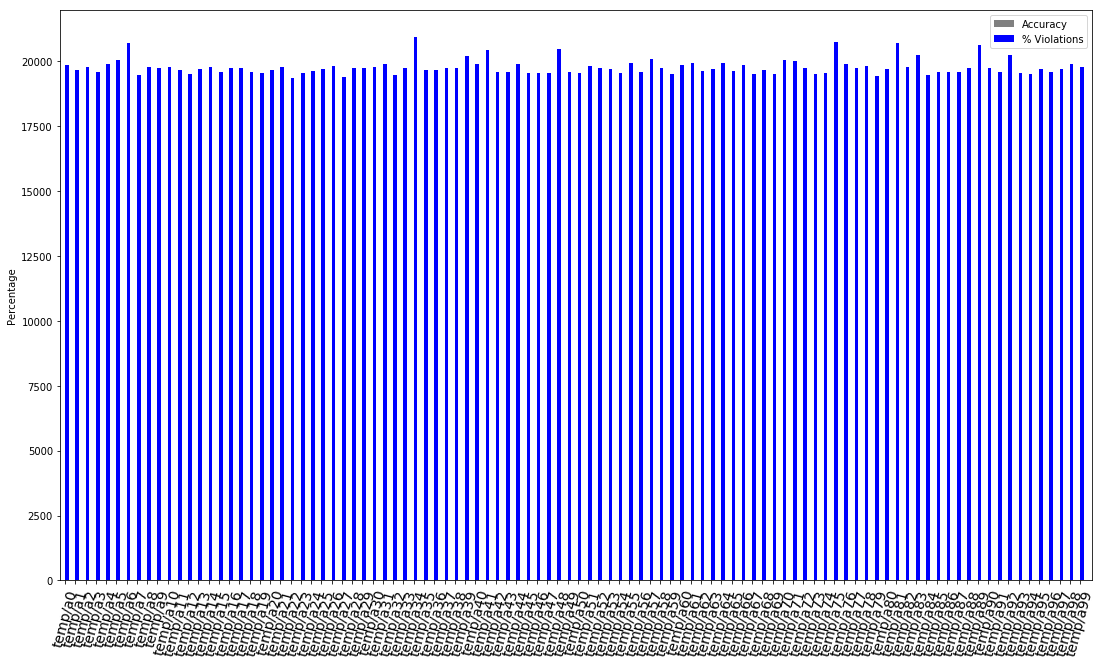

In [4]:
#the number of times to sample
times = 3
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    x_test_norm = normalize(df_test[inputs].values)
    y_test = df_test[target].values
    #bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
            
        predicted = model.predict(x_test_norm)[:,1]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(predicted,columns = target)
        test_df = test_df.join(test_targets)
       
        
    
        mean[idx][t] = roc_auc_score(y_test, predicted) 
        test_df[test_df['cancer'] > 0.5] = 1
        test_df[test_df['cancer'] <= 0.5] = 0
        bic_pred = get_bic(test_df,prior)
        
        #bic_pred = get_bic(df_test.join(pd.DataFrame(model.predict(x_test), columns = ['target'])), prior)
        
        print(tetrad.getEdges())
        print(bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(metrics_dicts[i])


Best by BIC =  0.693430843476607
Best by AUC =  0.693782688284519
Best by MET =  0.692839779859262
Random =  0.6931610165462153
-0.029339015216299124


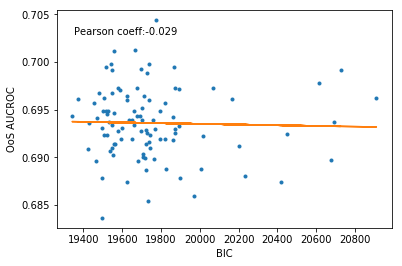

0.030409193256815382


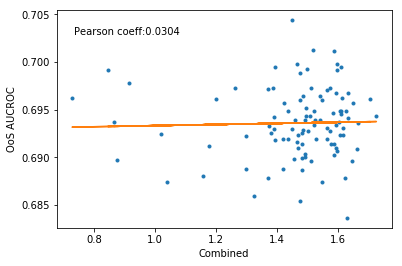

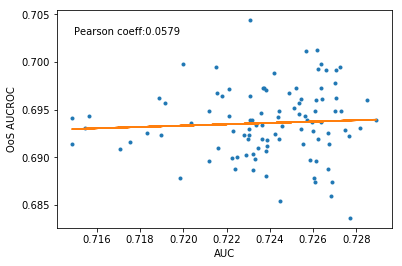

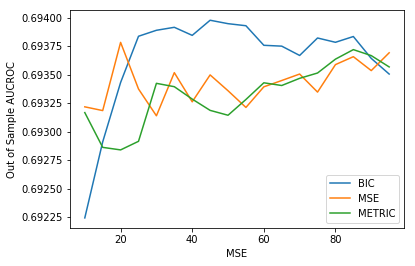

0.030409193256815382

In [5]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(-np.array(VIO)) + np.array(MSE)
n_low = int(num_models * 0.2)
sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]

print("Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("Best by AUC = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("Best by MET = ", np.mean(sorted_aus[:n_low]))

#sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("Random = ", np.mean(AUS[:n_low]))

print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:6], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:6], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Combined")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:6], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("AUC")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low)) 
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("Out of Sample AUCROC")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

model.predict(X)

array([[0.69748163, 0.30251837],
       [0.33234844, 0.6676516 ],
       [0.52037275, 0.47962725],
       ...,
       [0.3269573 , 0.6730427 ],
       [0.904066  , 0.09593401],
       [0.8770836 , 0.12291645]], dtype=float32)

In [7]:
sfm = SelectFromModel(model, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

TypeError: Cannot clone object '<keras.engine.training.Model object at 0x7f9e101656a0>' (type <class 'keras.engine.training.Model'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.